In [1]:
import ipyleaflet

In [2]:
from ipyleaflet import (
    Map,
    Marker,
    TileLayer, ImageOverlay,
    Polyline, Polygon, Rectangle, Circle, CircleMarker,
    GeoJSON,
    DrawControl
)

## Visualizing the distribution of the observations

## Load the required libraries

In [3]:
import pandas as pd
import numpy as np
import sklearn as sk
import urllib
import math

In [4]:
import findspark
findspark.init()

from pyspark import SparkContext
#sc.stop()
sc = SparkContext(master="local[3]",pyFiles=['lib/numpy_pack.py','lib/spark_PCA.py','lib/computeStats.py'])

from pyspark import SparkContext
from pyspark.sql import *
sqlContext = SQLContext(sc)

In [5]:
import sys
sys.path.append('./lib')

import numpy as np
from numpy_pack import packArray,unpackArray
from spark_PCA import computeCov
from computeStats import computeOverAllDist, STAT_Descriptions

In [18]:
stations_pdf=pd.read_csv(data_dir+'/US_stations.tsv',sep='\t')
stations_pdf.head(3)
#stations_df=sqlContext.createDataFrame?
#(stations_pdf)
#stations_df.show(3)

NameError: name 'stations_df' is not defined

In [ ]:
stations_df=sqlContext.createDataFrame

In [19]:
### Read the data frame from pickle file

data_dir='../../Data/Weather'
state='NY'
meas='SNWD'
!ls -l $data_dir

total 289816
drwxr-xr-x    17 yoavfreund  staff       544 Mar 16 13:27 CA.parquet
-rw-r--r--     1 yoavfreund  staff  38154057 Mar 17 16:47 CA.tgz
-rw-r--r--     1 yoavfreund  staff     25213 Mar 14 20:19 Depickle dist_to_coast.ipynb
drwxr-xr-x  2380 yoavfreund  staff     76160 Mar 25 16:39 Joined_smoothed_PRCP.parquet
drwxr-xr-x    17 yoavfreund  staff       544 Mar 25 15:56 NY.parquet
-rw-r--r--     1 yoavfreund  staff  23182008 Mar 25 15:56 NY.tgz
drwxr-xr-x    17 yoavfreund  staff       544 Mar 18 20:19 RI.parquet
-rw-r--r--     1 yoavfreund  staff    684201 Mar 18 20:19 RI.tgz
-rw-r--r--     1 yoavfreund  staff  25684434 Mar 25 15:56 STAT_NY.pickle
-rw-r--r--     1 yoavfreund  staff  11717259 Mar 18 20:19 STAT_RI.pickle.gz
-rw-r--r--     1 yoavfreund  staff  13522496 Mar 10 12:06 STAT_SSSSBBBB.pickle.gz
-rw-r--r--     1 yoavfreund  staff  12456904 Mar 10 12:06 US_Weather_BBSSBBSS.csv
-rw-r--r--     1 yoavfreund  staff   3430874 Mar 10 12:06 US_Weather_BBSSBBSS.csv.gz
drwxr-xr-x   

In [16]:
from pickle import load

#read statistics
filename=data_dir+'/STAT_%s.pickle'%state
STAT,STAT_Descriptions = load(open(filename,'rb'))
print('keys from STAT=',STAT.keys())

#!ls -ld $data_dir/*.parquet

#read data
filename=data_dir+'/decon_%s_%s.parquet'%(state,meas)

df=sqlContext.read.parquet(filename)
print(df.count())
df.show(2)

keys from STAT= dict_keys(['TMAX', 'SNOW', 'SNWD', 'TMIN', 'PRCP', 'TOBS'])
8026
+-----------+-----+-----------+--------------------+----+-----------------+-----------------+------------------+------------------+--------------------+--------------------+------------------+-----------+
|Measurement|State|    Station|              Values|Year|          coeff_1|          coeff_2|           coeff_3|             res_1|               res_2|               res_3|          res_mean|  total_var|
+-----------+-----+-----------+--------------------+----+-----------------+-----------------+------------------+------------------+--------------------+--------------------+------------------+-----------+
|       SNWD|   NY|USC00306411|[F6 60 8E 61 C2 6...|1945|5053.259734988232|4339.126273974123|-664.2787305691834| 0.395372926920007|0.021843296029783375|0.014758952247593979|0.7004236682602922|6.5071034E7|
|       SNWD|   NY|USC00303102|[5A 62 8A 63 24 6...|1945|6204.511279659803|2949.545596719011|-1078.

In [12]:
#extract longitude and latitude for each station
feature='coeff_1'
sqlContext.registerDataFrameAsTable(df,'weather')
Query="SELECT station, latitude,longitude,elevation,%s FROM weather"%feature
print(Query)
df1 = sqlContext.sql(Query)
df1.show(4)

SELECT station, latitude,longitude,elevation,coeff_1 FROM weather


AnalysisException: "cannot resolve '`latitude`' given input columns: [weather.coeff_2, weather.coeff_3, weather.res_3, weather.Year, weather.Values, weather.State, weather.total_var, weather.coeff_1, weather.Station, weather.res_mean, weather.res_1, weather.Measurement, weather.res_2]; line 1 pos 16;\n'Project [station#2, 'latitude, 'longitude, 'elevation, coeff_1#5]\n+- SubqueryAlias weather\n   +- Relation[Measurement#0,State#1,Station#2,Values#3,Year#4L,coeff_1#5,coeff_2#6,coeff_3#7,res_1#8,res_2#9,res_3#10,res_mean#11,total_var#12] parquet\n"

In [8]:
df2=df1.groupby(['station','latitude','longitude','elevation']).agg({"station": "count", feature: "mean"})
pdf=df2.toPandas()
pdf.sort_values(by=['station'],inplace=True)
pdf.head(2)

station  latitude  longitude  elevation  count(station)  avg(coeff_1)
47  USC00190120   42.3861   -72.5375       43.3              48    189.866361
15  USC00190166   42.4167   -71.1833       54.9               1   -141.267870

In [9]:
#define a mapping from the range of the value to hex colors.
from matplotlib.colors import rgb2hex
_avg='avg(%s)'%feature
_min=pdf[_avg].min()
_max=pdf[_avg].max()
_min,_max

import pylab as plt
cmap=plt.get_cmap('jet')
def get_color(val):
    x=(val-_min)/(_max-_min)
    return(rgb2hex(cmap(x)[:3]))

get_color(1000.)

u'#73ff83'

## Map

In [10]:
min_lat,max_lat,min_long,max_long = box = (42.1103, 42.6167, -72.6, -70.8)


center = [(min_lat+max_lat)/2, (min_long+max_long)/2]
zoom = 9

m = Map(default_tiles=TileLayer(opacity=1.0), center=center, zoom=zoom)

r = Rectangle(bounds=[[min_lat,min_long],[max_lat,max_long]], weight=5, fill_opacity=0.0)
m += r

lat_margin=(max_lat-min_lat)/4
long_margin=(max_long-min_long)/4
circles = []
for index,row in pdf.iterrows():
    _lat=row['latitude']
    _long=row['longitude']
    _count=row['count(station)']
    _coef=row[_avg]
    # taking sqrt of count so that the  area of the circle corresponds to the count
    c = Circle(location=(_lat,_long), radius=int(300*np.sqrt(_count+0.0)), weight=1,
            color='#F00', opacity=0.8, fill_opacity=0.4,
            fill_color=get_color(_coef))
    circles.append(c)
    m.add_layer(c)
m    

### excercises:
* Add a legend that relates the colors to values.
* Leaflet supports a variety of maps. See if you can get a topographical map as the background.

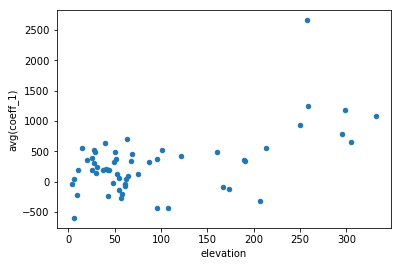

In [11]:
%matplotlib inline
pdf.plot.scatter(x='elevation',y='avg(coeff_1)');